In [10]:
!pip install prettytable

In [1]:
from monai.data import ArrayDataset, DataLoader, PILReader

In [2]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from collections.abc import Callable

from monai.transforms import ToTensor

from data_utils import *
from VGGLoss import *
from Generator import *
from Discriminator import *

from prettytable import PrettyTable


In [34]:
class TestHandler():
    def __init__(self,
                 patch_iterator: torch.utils.data.IterableDataset,
                 model: GeneratorUnet,
                 model_checkpoint: str=None,
                 output_dir: str="./output",
                ) -> None:
        self.patch_iterator = patch_iterator
        self.output_dir = output_dir
        
#         self.model_args = model_args 
        self.model_checkpoint = model_checkpoint
#         self.model_constructor = model_constructor
        self.device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
        
#         self.model = model_constructor(**model_args) if model_args is not None else model_constructor()
#         self.model = self.model.to(self.device)
        self.model = model.to(self.device)
        self.model.eval()
#         try:
        print(f'Loading checkpoint: {self.model_checkpoint}')
        chkp = torch.load(self.model_checkpoint)
        self.model.load_state_dict(chkp["model_state_dict"])
#         except:
#             print("The Checkpoint cannot loaded. Check the given path:\n",
#                   model_checkpoint)
#             return
    
    def generate_patch_iterator(self, image_list):
        for img_tuple in image_list:
            dir_name, fname = img_tuple[0].split("/")[-2:]
            img_prefix = fname[:-16]
            dataset = self.patch_iterator(data=img_tuple,
                                          patch_size=256,
                                          overlap_ratio=0.5,
                                          data_reader=PILReader())
            data_loader = DataLoader(dataset,
                                     batch_size=8,
                                     shuffle=False)
            yield dir_name, img_prefix, data_loader

    def run_test(self, image_list):
        with torch.no_grad():
            for dir_name, img_prefix, data_loader in tqdm(self.generate_patch_iterator(image_list),
                                                             total=len(image_list),
                                                             file=sys.stdout):
                patchesC01, patchesC02, patchesC03 = [], [], []
                for batch_index, batch in enumerate(data_loader):
                    # unpack the inputs
                    inpZ01, inpZ02, inpZ03, inpZ04, inpZ05, inpZ06, inpZ07 = \
                        batch[:,:,0,:,:].to(self.device), \
                        batch[:,:,1,:,:].to(self.device), \
                        batch[:,:,2,:,:].to(self.device), \
                        batch[:,:,3,:,:].to(self.device), \
                        batch[:,:,4,:,:].to(self.device), \
                        batch[:,:,5,:,:].to(self.device), \
                        batch[:,:,6,:,:].to(self.device)
                    # unpack the targets
                    targetC01, targetC02, targetC03 = batch[:,:,7,:,:].to(self.device), \
                        batch[:,:,8,:,:].to(self.device), \
                        batch[:,:,9,:,:].to(self.device)
                    # predict with model
                    outC01, outC02, outC03 = self.model(inpZ01, inpZ02, inpZ03, 
                                                        inpZ04, inpZ05, inpZ06, inpZ07)
                    
                    outC01, outC02, outC03 = [p[0] for p in outC01.data.cpu()], \
                                             [p[0] for p in outC02.data.cpu()], \
                                             [p[0] for p in outC03.data.cpu()]
                    # TODO: compute loss/metric 
                    # TODO: Create a good functions of losses if it is possible!
                    # 
#                     return outC01
                    patchesC01.extend(outC01)
                    patchesC02.extend(outC02)
                    patchesC03.extend(outC03)
                # (3,256,256)
                merged_images = []
                for i, patches in enumerate([patchesC01, patchesC02, patchesC03]):
                    print(len(patches))
                    print(patches[0].shape)
                    merged_img = data_loader.dataset.merge_patches(patches)
                    merged_img = (merged_img * 30000.0).astype("int64")
#                     merged_img = np.exp(merged_img * 5.5 + 5.5) - 1
                    
                    merged_images.append(merged_img)
                    # transform back to 16bits. Applied transformation in the training:
                    # vol = (np.log(1 + input_) - 5.5)/5.5
                    
                    out_dir = os.path.join(self.output_dir, dir_name)
                    if not os.path.exists(out_dir):
                        os.makedirs(out_dir)
                    self.save_img(merged_img, 
                                  os.path.join(out_dir,
                                               f"{img_prefix}L01A0{i+1}Z01C0{i+1}.tif"))
            return [patchesC01, patchesC02, patchesC03]
                
                
    @staticmethod
    def save_img(img,
                 output_path):
        # write 16-bit TIFF image
        if type(img) != np.ndarray:
            img = np.ndarray(img)
        # PIL interprets mode 'I;16' as "uint16, little-endian"
        img_out = Image.new('I;16', img.shape)
        # make sure u16in little-endian, output bytes
        outpil = img.astype(img.dtype.newbyteorder("<")).tobytes()
        # save it with the img_out
        img_out.frombytes(outpil)
        img_out.save(output_path)

In [66]:
model = GeneratorUnet()
model_chkp_path = "checkpoints/BESTTRAINING3/G_epoch_50.pth"
patch_iterator = OverlappyGridyDataset

In [13]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)


+----------------------------------------+------------+
|                Modules                 | Parameters |
+----------------------------------------+------------+
|       inc1.double_conv.0.weight        |    144     |
|        inc1.double_conv.0.bias         |     16     |
|       inc1.double_conv.2.weight        |     16     |
|        inc1.double_conv.2.bias         |     16     |
|       inc1.double_conv.4.weight        |    2304    |
|        inc1.double_conv.4.bias         |     16     |
|       inc1.double_conv.6.weight        |     16     |
|        inc1.double_conv.6.bias         |     16     |
|       inc2.double_conv.0.weight        |    144     |
|        inc2.double_conv.0.bias         |     16     |
|       inc2.double_conv.2.weight        |     16     |
|        inc2.double_conv.2.bias         |     16     |
|       inc2.double_conv.4.weight        |    2304    |
|        inc2.double_conv.4.bias         |     16     |
|       inc2.double_conv.6.weight        |     1

52763091

In [67]:
test_handler = TestHandler(patch_iterator,
                           model=model,
                           model_checkpoint=model_chkp_path)

Loading checkpoint: checkpoints/BESTTRAINING3/G_epoch_50.pth


RuntimeError: Error(s) in loading state_dict for GeneratorUnet:
	Missing key(s) in state_dict: "inc1.double_conv.2.weight", "inc1.double_conv.2.bias", "inc1.double_conv.2.running_mean", "inc1.double_conv.2.running_var", "inc1.double_conv.6.weight", "inc1.double_conv.6.bias", "inc1.double_conv.6.running_mean", "inc1.double_conv.6.running_var", "inc2.double_conv.2.weight", "inc2.double_conv.2.bias", "inc2.double_conv.2.running_mean", "inc2.double_conv.2.running_var", "inc2.double_conv.6.weight", "inc2.double_conv.6.bias", "inc2.double_conv.6.running_mean", "inc2.double_conv.6.running_var", "inc3.double_conv.2.weight", "inc3.double_conv.2.bias", "inc3.double_conv.2.running_mean", "inc3.double_conv.2.running_var", "inc3.double_conv.6.weight", "inc3.double_conv.6.bias", "inc3.double_conv.6.running_mean", "inc3.double_conv.6.running_var", "inc4.double_conv.2.weight", "inc4.double_conv.2.bias", "inc4.double_conv.2.running_mean", "inc4.double_conv.2.running_var", "inc4.double_conv.6.weight", "inc4.double_conv.6.bias", "inc4.double_conv.6.running_mean", "inc4.double_conv.6.running_var", "inc5.double_conv.2.weight", "inc5.double_conv.2.bias", "inc5.double_conv.2.running_mean", "inc5.double_conv.2.running_var", "inc5.double_conv.6.weight", "inc5.double_conv.6.bias", "inc5.double_conv.6.running_mean", "inc5.double_conv.6.running_var", "inc6.double_conv.2.weight", "inc6.double_conv.2.bias", "inc6.double_conv.2.running_mean", "inc6.double_conv.2.running_var", "inc6.double_conv.6.weight", "inc6.double_conv.6.bias", "inc6.double_conv.6.running_mean", "inc6.double_conv.6.running_var", "inc7.double_conv.2.weight", "inc7.double_conv.2.bias", "inc7.double_conv.2.running_mean", "inc7.double_conv.2.running_var", "inc7.double_conv.6.weight", "inc7.double_conv.6.bias", "inc7.double_conv.6.running_mean", "inc7.double_conv.6.running_var", "down1.pool_conv.1.double_conv.2.weight", "down1.pool_conv.1.double_conv.2.bias", "down1.pool_conv.1.double_conv.2.running_mean", "down1.pool_conv.1.double_conv.2.running_var", "down1.pool_conv.1.double_conv.6.weight", "down1.pool_conv.1.double_conv.6.bias", "down1.pool_conv.1.double_conv.6.running_mean", "down1.pool_conv.1.double_conv.6.running_var", "down2.pool_conv.1.double_conv.2.weight", "down2.pool_conv.1.double_conv.2.bias", "down2.pool_conv.1.double_conv.2.running_mean", "down2.pool_conv.1.double_conv.2.running_var", "down2.pool_conv.1.double_conv.6.weight", "down2.pool_conv.1.double_conv.6.bias", "down2.pool_conv.1.double_conv.6.running_mean", "down2.pool_conv.1.double_conv.6.running_var", "down3.pool_conv.1.double_conv.2.weight", "down3.pool_conv.1.double_conv.2.bias", "down3.pool_conv.1.double_conv.2.running_mean", "down3.pool_conv.1.double_conv.2.running_var", "down3.pool_conv.1.double_conv.6.weight", "down3.pool_conv.1.double_conv.6.bias", "down3.pool_conv.1.double_conv.6.running_mean", "down3.pool_conv.1.double_conv.6.running_var", "down4.pool_conv.1.double_conv.2.weight", "down4.pool_conv.1.double_conv.2.bias", "down4.pool_conv.1.double_conv.2.running_mean", "down4.pool_conv.1.double_conv.2.running_var", "down4.pool_conv.1.double_conv.6.weight", "down4.pool_conv.1.double_conv.6.bias", "down4.pool_conv.1.double_conv.6.running_mean", "down4.pool_conv.1.double_conv.6.running_var", "up1.conv.double_conv.2.weight", "up1.conv.double_conv.2.bias", "up1.conv.double_conv.2.running_mean", "up1.conv.double_conv.2.running_var", "up1.conv.double_conv.6.weight", "up1.conv.double_conv.6.bias", "up1.conv.double_conv.6.running_mean", "up1.conv.double_conv.6.running_var", "up2.conv.double_conv.2.weight", "up2.conv.double_conv.2.bias", "up2.conv.double_conv.2.running_mean", "up2.conv.double_conv.2.running_var", "up2.conv.double_conv.6.weight", "up2.conv.double_conv.6.bias", "up2.conv.double_conv.6.running_mean", "up2.conv.double_conv.6.running_var", "up3.conv.double_conv.2.weight", "up3.conv.double_conv.2.bias", "up3.conv.double_conv.2.running_mean", "up3.conv.double_conv.2.running_var", "up3.conv.double_conv.6.weight", "up3.conv.double_conv.6.bias", "up3.conv.double_conv.6.running_mean", "up3.conv.double_conv.6.running_var", "up4.conv.double_conv.2.weight", "up4.conv.double_conv.2.bias", "up4.conv.double_conv.2.running_mean", "up4.conv.double_conv.2.running_var", "up4.conv.double_conv.6.weight", "up4.conv.double_conv.6.bias", "up4.conv.double_conv.6.running_mean", "up4.conv.double_conv.6.running_var". 
	Unexpected key(s) in state_dict: "inc1.double_conv.1.weight", "inc1.double_conv.1.bias", "inc1.double_conv.1.running_mean", "inc1.double_conv.1.running_var", "inc1.double_conv.1.num_batches_tracked", "inc1.double_conv.3.weight", "inc1.double_conv.3.bias", "inc1.double_conv.4.running_mean", "inc1.double_conv.4.running_var", "inc1.double_conv.4.num_batches_tracked", "inc2.double_conv.1.weight", "inc2.double_conv.1.bias", "inc2.double_conv.1.running_mean", "inc2.double_conv.1.running_var", "inc2.double_conv.1.num_batches_tracked", "inc2.double_conv.3.weight", "inc2.double_conv.3.bias", "inc2.double_conv.4.running_mean", "inc2.double_conv.4.running_var", "inc2.double_conv.4.num_batches_tracked", "inc3.double_conv.1.weight", "inc3.double_conv.1.bias", "inc3.double_conv.1.running_mean", "inc3.double_conv.1.running_var", "inc3.double_conv.1.num_batches_tracked", "inc3.double_conv.3.weight", "inc3.double_conv.3.bias", "inc3.double_conv.4.running_mean", "inc3.double_conv.4.running_var", "inc3.double_conv.4.num_batches_tracked", "inc4.double_conv.1.weight", "inc4.double_conv.1.bias", "inc4.double_conv.1.running_mean", "inc4.double_conv.1.running_var", "inc4.double_conv.1.num_batches_tracked", "inc4.double_conv.3.weight", "inc4.double_conv.3.bias", "inc4.double_conv.4.running_mean", "inc4.double_conv.4.running_var", "inc4.double_conv.4.num_batches_tracked", "inc5.double_conv.1.weight", "inc5.double_conv.1.bias", "inc5.double_conv.1.running_mean", "inc5.double_conv.1.running_var", "inc5.double_conv.1.num_batches_tracked", "inc5.double_conv.3.weight", "inc5.double_conv.3.bias", "inc5.double_conv.4.running_mean", "inc5.double_conv.4.running_var", "inc5.double_conv.4.num_batches_tracked", "inc6.double_conv.1.weight", "inc6.double_conv.1.bias", "inc6.double_conv.1.running_mean", "inc6.double_conv.1.running_var", "inc6.double_conv.1.num_batches_tracked", "inc6.double_conv.3.weight", "inc6.double_conv.3.bias", "inc6.double_conv.4.running_mean", "inc6.double_conv.4.running_var", "inc6.double_conv.4.num_batches_tracked", "inc7.double_conv.1.weight", "inc7.double_conv.1.bias", "inc7.double_conv.1.running_mean", "inc7.double_conv.1.running_var", "inc7.double_conv.1.num_batches_tracked", "inc7.double_conv.3.weight", "inc7.double_conv.3.bias", "inc7.double_conv.4.running_mean", "inc7.double_conv.4.running_var", "inc7.double_conv.4.num_batches_tracked", "down1.pool_conv.1.double_conv.1.weight", "down1.pool_conv.1.double_conv.1.bias", "down1.pool_conv.1.double_conv.1.running_mean", "down1.pool_conv.1.double_conv.1.running_var", "down1.pool_conv.1.double_conv.1.num_batches_tracked", "down1.pool_conv.1.double_conv.3.weight", "down1.pool_conv.1.double_conv.3.bias", "down1.pool_conv.1.double_conv.4.running_mean", "down1.pool_conv.1.double_conv.4.running_var", "down1.pool_conv.1.double_conv.4.num_batches_tracked", "down2.pool_conv.1.double_conv.1.weight", "down2.pool_conv.1.double_conv.1.bias", "down2.pool_conv.1.double_conv.1.running_mean", "down2.pool_conv.1.double_conv.1.running_var", "down2.pool_conv.1.double_conv.1.num_batches_tracked", "down2.pool_conv.1.double_conv.3.weight", "down2.pool_conv.1.double_conv.3.bias", "down2.pool_conv.1.double_conv.4.running_mean", "down2.pool_conv.1.double_conv.4.running_var", "down2.pool_conv.1.double_conv.4.num_batches_tracked", "down3.pool_conv.1.double_conv.1.weight", "down3.pool_conv.1.double_conv.1.bias", "down3.pool_conv.1.double_conv.1.running_mean", "down3.pool_conv.1.double_conv.1.running_var", "down3.pool_conv.1.double_conv.1.num_batches_tracked", "down3.pool_conv.1.double_conv.3.weight", "down3.pool_conv.1.double_conv.3.bias", "down3.pool_conv.1.double_conv.4.running_mean", "down3.pool_conv.1.double_conv.4.running_var", "down3.pool_conv.1.double_conv.4.num_batches_tracked", "down4.pool_conv.1.double_conv.1.weight", "down4.pool_conv.1.double_conv.1.bias", "down4.pool_conv.1.double_conv.1.running_mean", "down4.pool_conv.1.double_conv.1.running_var", "down4.pool_conv.1.double_conv.1.num_batches_tracked", "down4.pool_conv.1.double_conv.3.weight", "down4.pool_conv.1.double_conv.3.bias", "down4.pool_conv.1.double_conv.4.running_mean", "down4.pool_conv.1.double_conv.4.running_var", "down4.pool_conv.1.double_conv.4.num_batches_tracked", "up1.conv.double_conv.1.weight", "up1.conv.double_conv.1.bias", "up1.conv.double_conv.1.running_mean", "up1.conv.double_conv.1.running_var", "up1.conv.double_conv.1.num_batches_tracked", "up1.conv.double_conv.3.weight", "up1.conv.double_conv.3.bias", "up1.conv.double_conv.4.running_mean", "up1.conv.double_conv.4.running_var", "up1.conv.double_conv.4.num_batches_tracked", "up2.conv.double_conv.1.weight", "up2.conv.double_conv.1.bias", "up2.conv.double_conv.1.running_mean", "up2.conv.double_conv.1.running_var", "up2.conv.double_conv.1.num_batches_tracked", "up2.conv.double_conv.3.weight", "up2.conv.double_conv.3.bias", "up2.conv.double_conv.4.running_mean", "up2.conv.double_conv.4.running_var", "up2.conv.double_conv.4.num_batches_tracked", "up3.conv.double_conv.1.weight", "up3.conv.double_conv.1.bias", "up3.conv.double_conv.1.running_mean", "up3.conv.double_conv.1.running_var", "up3.conv.double_conv.1.num_batches_tracked", "up3.conv.double_conv.3.weight", "up3.conv.double_conv.3.bias", "up3.conv.double_conv.4.running_mean", "up3.conv.double_conv.4.running_var", "up3.conv.double_conv.4.num_batches_tracked", "up4.conv.double_conv.1.weight", "up4.conv.double_conv.1.bias", "up4.conv.double_conv.1.running_mean", "up4.conv.double_conv.1.running_var", "up4.conv.double_conv.1.num_batches_tracked", "up4.conv.double_conv.3.weight", "up4.conv.double_conv.3.bias", "up4.conv.double_conv.4.running_mean", "up4.conv.double_conv.4.running_var", "up4.conv.double_conv.4.num_batches_tracked". 
	size mismatch for inc1.double_conv.0.weight: copying a param with shape torch.Size([8, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3]).
	size mismatch for inc1.double_conv.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc1.double_conv.4.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for inc1.double_conv.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc2.double_conv.0.weight: copying a param with shape torch.Size([8, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3]).
	size mismatch for inc2.double_conv.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc2.double_conv.4.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for inc2.double_conv.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc3.double_conv.0.weight: copying a param with shape torch.Size([8, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3]).
	size mismatch for inc3.double_conv.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc3.double_conv.4.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for inc3.double_conv.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc4.double_conv.0.weight: copying a param with shape torch.Size([8, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3]).
	size mismatch for inc4.double_conv.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc4.double_conv.4.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for inc4.double_conv.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc5.double_conv.0.weight: copying a param with shape torch.Size([8, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3]).
	size mismatch for inc5.double_conv.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc5.double_conv.4.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for inc5.double_conv.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc6.double_conv.0.weight: copying a param with shape torch.Size([8, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3]).
	size mismatch for inc6.double_conv.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc6.double_conv.4.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for inc6.double_conv.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc7.double_conv.0.weight: copying a param with shape torch.Size([8, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3]).
	size mismatch for inc7.double_conv.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for inc7.double_conv.4.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for inc7.double_conv.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for down1.pool_conv.1.double_conv.0.weight: copying a param with shape torch.Size([112, 56, 3, 3]) from checkpoint, the shape in current model is torch.Size([224, 112, 3, 3]).
	size mismatch for down1.pool_conv.1.double_conv.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for down1.pool_conv.1.double_conv.4.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([224, 224, 3, 3]).
	size mismatch for down1.pool_conv.1.double_conv.4.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for down2.pool_conv.1.double_conv.0.weight: copying a param with shape torch.Size([224, 112, 3, 3]) from checkpoint, the shape in current model is torch.Size([448, 224, 3, 3]).
	size mismatch for down2.pool_conv.1.double_conv.0.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for down2.pool_conv.1.double_conv.4.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([448, 448, 3, 3]).
	size mismatch for down2.pool_conv.1.double_conv.4.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for down3.pool_conv.1.double_conv.0.weight: copying a param with shape torch.Size([448, 224, 3, 3]) from checkpoint, the shape in current model is torch.Size([896, 448, 3, 3]).
	size mismatch for down3.pool_conv.1.double_conv.0.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([896]).
	size mismatch for down3.pool_conv.1.double_conv.4.weight: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([896, 896, 3, 3]).
	size mismatch for down3.pool_conv.1.double_conv.4.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([896]).
	size mismatch for down4.pool_conv.1.double_conv.0.weight: copying a param with shape torch.Size([448, 448, 3, 3]) from checkpoint, the shape in current model is torch.Size([896, 896, 3, 3]).
	size mismatch for down4.pool_conv.1.double_conv.0.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([896]).
	size mismatch for down4.pool_conv.1.double_conv.4.weight: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([896, 896, 3, 3]).
	size mismatch for down4.pool_conv.1.double_conv.4.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([896]).
	size mismatch for up1.conv.double_conv.0.weight: copying a param with shape torch.Size([448, 896, 3, 3]) from checkpoint, the shape in current model is torch.Size([896, 1792, 3, 3]).
	size mismatch for up1.conv.double_conv.0.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([896]).
	size mismatch for up1.conv.double_conv.4.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([448, 896, 3, 3]).
	size mismatch for up1.conv.double_conv.4.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for up2.conv.double_conv.0.weight: copying a param with shape torch.Size([224, 448, 3, 3]) from checkpoint, the shape in current model is torch.Size([448, 896, 3, 3]).
	size mismatch for up2.conv.double_conv.0.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for up2.conv.double_conv.4.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([224, 448, 3, 3]).
	size mismatch for up2.conv.double_conv.4.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for up3.conv.double_conv.0.weight: copying a param with shape torch.Size([112, 224, 3, 3]) from checkpoint, the shape in current model is torch.Size([224, 448, 3, 3]).
	size mismatch for up3.conv.double_conv.0.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for up3.conv.double_conv.4.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([112, 224, 3, 3]).
	size mismatch for up3.conv.double_conv.4.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for up4.conv.double_conv.0.weight: copying a param with shape torch.Size([56, 112, 3, 3]) from checkpoint, the shape in current model is torch.Size([112, 224, 3, 3]).
	size mismatch for up4.conv.double_conv.0.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for up4.conv.double_conv.4.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([112, 112, 3, 3]).
	size mismatch for up4.conv.double_conv.4.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for outc1.conv.weight: copying a param with shape torch.Size([1, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 112, 1, 1]).
	size mismatch for outc2.conv.weight: copying a param with shape torch.Size([1, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 112, 1, 1]).
	size mismatch for outc3.conv.weight: copying a param with shape torch.Size([1, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 112, 1, 1]).

In [36]:
img_tuple = [('/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z01C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z02C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z03C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z04C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z05C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z06C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z07C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A01Z01C01.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A02Z01C02.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A03Z01C03.tif')
]
smt = test_handler.run_test(img_tuple)

  0%|          | 0/1 [00:00<?, ?it/s]340
torch.Size([256, 256])
340
torch.Size([256, 256])
340
torch.Size([256, 256])
100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


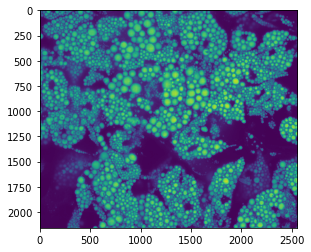

In [19]:
import matplotlib.pyplot as plt
p = '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A02Z01C02.tif'
img = plt.imread(p)
img = np.array(img)
plt.imshow(img)

In [18]:
smt

array([[0.08624437, 0.08071498, 0.11599903, ..., 0.0442095 , 0.09358028,
        0.0621633 ],
       [0.06077574, 0.04498141, 0.10474542, ..., 0.06440791, 0.01260866,
        0.07821665],
       [0.07935937, 0.07160197, 0.08553996, ..., 0.06857628, 0.02740914,
        0.04121411],
       ...,
       [0.05872754, 0.03189902, 0.08653544, ..., 0.02951692, 0.04588683,
        0.06756452],
       [0.01979233, 0.05905347, 0.02199507, ..., 0.07861591, 0.09513701,
        0.12799869],
       [0.08872975, 0.0298917 , 0.04337167, ..., 0.02136015, 0.05219861,
        0.05686291]])

In [32]:
img = (np.log(1 + img) - 5.5)/5.5

invalid value encountered in log


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


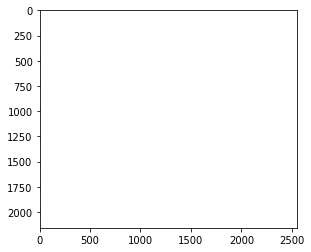

In [39]:
plt.imshow(np.stack(smt, axis=-1))

In [27]:
smt[0]

array([[ 601,  332,  392, ...,  488,  480,  431],
       [ 441,  299,  598, ...,  931,  596,  479],
       [ 608,  885, 1258, ..., 1472, 1260,  662],
       ...,
       [ 931, 1657, 1558, ..., 1359, 1363,  777],
       [ 735, 1084, 1527, ..., 1275,  839,  527],
       [ 568,  497,  690, ...,  572,  428,  496]])

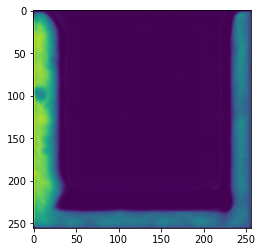

In [43]:
plt.imshow(smt[2][50])

In [78]:
smt[1][~np.isnan(smt[1])].max(), img.max()

(8180.921202932452, 3913)

In [79]:
np.mean(np.power(np.log(smt[1][:1800,:1800])-np.log(img[:1800,:1800]), 2))

0.3275690310623606

In [1]:
img_tuple = [('/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z01C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z02C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z03C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z04C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z05C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z06C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z07C04.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A01Z01C01.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A02Z01C02.tif',
             '/data/40x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A03Z01C03.tif')
]

In [2]:
import matplotlib.pyplot as plt
imgs = [plt.imread(p) for p in img_tuple[0]]

In [3]:
import numpy as np

In [4]:
c01 = imgs[-3]
c02 = imgs[-2]
c03 = imgs[-1]
bf = imgs[:7]

In [59]:
plt.imsave("asd.png", c03/np.max(bf, axis=0))

In [60]:
a = c03/np.mean(bf, axis=0)

In [61]:
print(a.min())
print(a.max())
print(a.mean())

0.05626326963906582
5.536853685368537
0.6016109812420996


In [55]:
len(a[a>5])

0

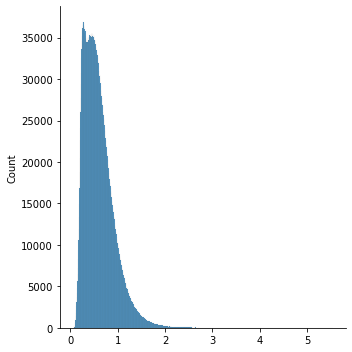

In [62]:
import seaborn as sns
sns.displot(a.ravel())

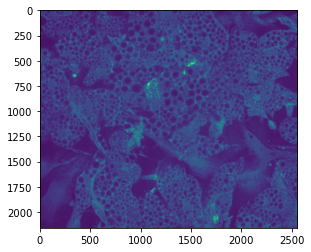

In [27]:
plt.imshow(c03)

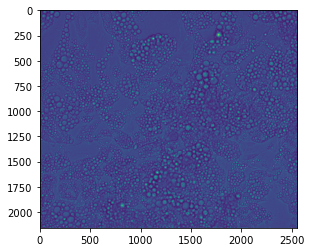

In [12]:
plt.imshow(np.max(bf, axis=0)-np.mena(bf, axis=0))

In [48]:
a = 100
b = 10000

np.log(a) - np.log(b), a-b, a/10 - b/10

(-4.605170185988092, -9900, -990.0)

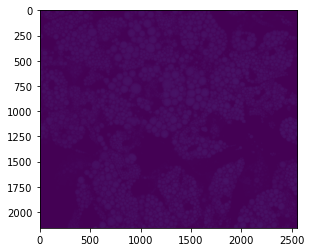

In [62]:
img[0,0] = 15000
plt.imshow(img/65535, vmin=0, vmax=1)

In [50]:
img.max()

3913

In [59]:
img

array([[   0,  774,  749, ...,   18,   23,   22],
       [1075,    0,  857, ...,   16,   23,    8],
       [1060,  963,  904, ...,   30,   23,   20],
       ...,
       [  72,   35,   66, ..., 2200, 2098, 2173],
       [  35,   43,   54, ..., 2212, 2245, 2179],
       [  46,   31,   31, ..., 2090, 2125, 2169]], dtype=uint16)

In [65]:
np.exp(0), np.exp(11)

(1.0, 59874.14171519782)

In [71]:
x = np.arange(-5.0, 5.0, 0.1)
y1 = 1/(1+np.exp(-x))
y2 = (1+np.tanh(x))/2

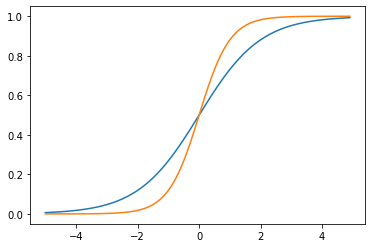

In [74]:
plt.plot(x, y1)
plt.plot(x, y2)